In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

# General stats
Avg number of steps, std...

In [80]:
mat = pd.read_csv("datasets/heatmap_4_narrow.csv",header=None).to_numpy()

In [81]:
solved_at = (mat==0).argmax(axis=1)
solved_at[solved_at==0] = mat.shape[1]

In [82]:
print(f'mean: {solved_at.mean()}, std: {solved_at.std()}, max: {solved_at.max()}')

mean: 13.766666666666667, std: 4.4172641105351875, max: 22


In [83]:
df = pd.read_csv('./datasets/steps.csv')
df = df.loc[df['tangram nr' ] ==4]

print(df['grid_val'].unique())
df = df[['sid','tangram nr','step']]
participants = df.groupby(['sid','tangram nr']).max()['step'].to_numpy()
participants = participants[participants<participants.mean()+participants.std()]
participants

[11. 23.  2. 13.  8.  9. 17.  7. 12.  3. 10. 14. 18. 19.]


array([13.,  7.,  7.,  8., 15.,  8.,  7.,  7.,  7.,  8.,  9., 10., 18.,
        9., 10.,  7.,  7.,  9.,  9., 11., 18., 19., 12., 11.,  7., 17.])

In [84]:
print(f'mean: {participants.mean()}, std: {participants.std()}, max: {participants.max()}')

mean: 10.384615384615385, std: 3.833826398269881, max: 19.0


# Heatmaps

In [85]:
heatmap = np.zeros((5,10))
for i in range(5):
    p = i+1
    for m in range(10):
        heatmap[i,m] = np.count_nonzero(mat[:,m] == p)


In [86]:
heatmap = heatmap/heatmap.sum(axis=0,keepdims=1)

In [87]:
data = np.loadtxt('datasets/heatmap4.txt')

In [88]:
rmse =np.sqrt(np.mean((heatmap-data)**2, axis=0))
print(rmse)

[0.16835977 0.17743695 0.13284858 0.10470932 0.14927427 0.40584753
 0.39794187 0.33855247 0.34860834 0.50860366]


In [89]:
np.mean(rmse)

0.2732182769822595

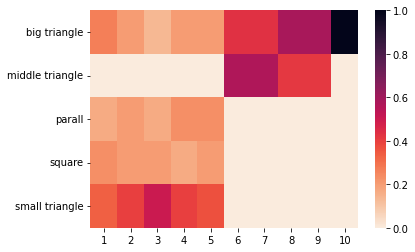

In [90]:
cmap = sns.cm.rocket_r
y_axis_labels = ['small triangle','square','parall','middle triangle','big triangle']
x_axis_labels = [1,2,3,4,5,6,7,8,9,10]
fig, ax = plt.subplots()
sns.heatmap(heatmap,ax=ax,yticklabels=y_axis_labels,xticklabels=x_axis_labels,cmap=cmap,vmin=0, vmax=1)
ax.invert_yaxis()
plt.show()


# Sequence evaluation

Tangram 2

In [91]:
users = pd.read_csv('datasets/train_states.csv')
users = users.loc[users['tangram nr'] ==4]
model = pd.read_csv('datasets/model_states_evolution_4_narrow.csv')

## Method1: step-by-step matching

For each run, the model gets its score by comparing the position at each step with user data at step +-1, scoring 1 point if there is any match

In [92]:
score = 0
max_score = 0
for run in model.run.unique():
    run_steps = model.loc[model.run == run]
    for step in range(3,12):
        
        state = run_steps.iloc[step][['small triangle','middle triangle','big triangle','square','parallelogram']]
        previous = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        last_state = run_steps.iloc[-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        if not (state.equals(last_state) and state.equals(previous)):
            max_score +=1
            users_at_step = users.loc[users['step'].isin([step-1,step,step+1])][['small triangle','middle triangle','big triangle','square','parallelogram']]
            res= users_at_step.loc[
                (users_at_step['small triangle'] == state['small triangle']) &
                (users_at_step['middle triangle'] == state['middle triangle']) &
                (users_at_step['big triangle'] == state['big triangle']) &
                (users_at_step['square'] == state['square']) &
                (users_at_step['parallelogram'] == state['parallelogram'])
            ]
            if not res.empty:
                score+=1
print(score)
print(max_score)
print(score/max_score)

113
214
0.5280373831775701


## Method1: rms

In [166]:
def state_diff(model,user):
    diff = 0
    for c in ['small triangle','middle triangle','big triangle','square','parallelogram']:
        if user[c] != model[c]:
            diff +=1
    return diff



errors = 10*np.ones((len(model.run.unique()),13))
for run in model.run.unique():
    run_steps = model.loc[model.run == run]
    for step in range(3,16):
        
        state = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        previous = run_steps.iloc[step-2][['small triangle','middle triangle','big triangle','square','parallelogram']]
        last_state = run_steps.iloc[-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        if not (state.equals(last_state) and state.equals(previous)):
            max_score +=1
            users_at_step = users.loc[users['step']==step][['small triangle','middle triangle','big triangle','square','parallelogram']]
            res = users_at_step.apply(lambda x: state_diff(state,x),axis=1)
            rmse = np.sqrt(np.mean((res)**2))
            errors[run,step-3] = rmse
#             res= users_at_step.loc[
#                 (users_at_step['small triangle'] == state['small triangle']) &
#                 (users_at_step['middle triangle'] == state['middle triangle']) &
#                 (users_at_step['big triangle'] == state['big triangle']) &
#                 (users_at_step['square'] == state['square']) &
#                 (users_at_step['parallelogram'] == state['parallelogram'])
#             ]


errors.min(axis=0)

array([2.29492193, 2.40138849, 2.20605228, 2.18326972, 2.34520788,
       2.20605228, 2.30940108, 2.10554823, 1.97484177, 2.25831796,
       2.20605228, 2.04939015, 2.01659779])

In [160]:
def state_diff(model,user):
    diff = 0
    for c in ['small triangle','middle triangle','big triangle','square','parallelogram']:
        if user[c] != model[c]:
            diff +=1
    return diff


score = 0
max_score = 0
errors = 10*np.ones((len(model.run.unique()),13))
for run in model.run.unique():
    run_steps = model.loc[model.run == run]
    for step in range(3,16):
        
        state = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        previous = run_steps.iloc[step-2][['small triangle','middle triangle','big triangle','square','parallelogram']]
        last_state = run_steps.iloc[-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
        if not (state.equals(last_state) and state.equals(previous)):
            max_score +=1
            users_at_step = users.loc[users['step']==step][['small triangle','middle triangle','big triangle','square','parallelogram']]
            res = users_at_step.apply(lambda x: state_diff(state,x),axis=1)
            errors[run,step-3] = min(res)
            if not res.empty:
                score+=1
print(score)
print(max_score)
 
print(score/max_score)

errors

305
305
1.0


array([[ 0.,  1.,  0.,  1.,  0.,  0., 10., 10., 10., 10., 10., 10., 10.],
       [ 1.,  1.,  1.,  2.,  2.,  2.,  1.,  2.,  1.,  0.,  0., 10., 10.],
       [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  2.,  2.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  0.,  1.,  1.,  2.,  1.,  1.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  0., 10.],
       [ 1.,  2.,  0.,  1.,  0.,  0., 10., 10., 10., 10., 10., 10., 10.],
       [ 0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  2.,  2.,  1.],
       [ 1.,  2.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.],
       [ 1.,  1.,  1.,  2.,  2.,  1.,  2.,  2.,  2.,  1.,  0., 10., 10.],
       [ 2.,  2.,  1.,  2.,  1.,  1.,  1.,  1.,  1.,  0., 10., 10., 10.],
       [ 1.,  0.,  1.,  2.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.],
       [ 1.,  1.,  1.,  0.,  1.,  1., 

In [74]:
step=3
users_at_step = users.loc[users['step']==step][['small triangle','middle triangle','big triangle','square','parallelogram']]
run_steps=  model.loc[model.run == 1]
state = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]



## Method2: phase-by-phase matching

For each run, the results is matched at step 4, 8 and 12, getting incremental points if such sequence also appears in participants data, some margin or error is accepted

In [72]:
score=0
same_seq= 0
for run in model.run.unique():

    run_steps = model.loc[model.run == run]
    
    #step 4
    step=4
    model_at_step = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
    users_at_step = users.loc[users['step'].isin(range(step-1,step+2))]
    res= users_at_step.loc[
                (users_at_step['small triangle'] == model_at_step['small triangle']) &
                (users_at_step['middle triangle'] == model_at_step['middle triangle']) &
                (users_at_step['big triangle'] == model_at_step['big triangle']) &
                (users_at_step['square'] == model_at_step['square']) &
                (users_at_step['parallelogram'] == model_at_step['parallelogram'])
            ]
    if res.empty:
        
        continue
    
    score +=1
    filtered=  users.loc[users['sid'].isin(res.sid.unique())]
    
    #step 8
    step = 8
    model_at_step = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
    users_at_step = users.loc[users['step'].isin(range(step-2,step+3))]
    res= users_at_step.loc[
                (users_at_step['small triangle'] == model_at_step['small triangle']) &
                (users_at_step['middle triangle'] == model_at_step['middle triangle']) &
                (users_at_step['big triangle'] == model_at_step['big triangle']) &
                (users_at_step['square'] == model_at_step['square']) &
                (users_at_step['parallelogram'] == model_at_step['parallelogram'])
            ]
    if res.empty:
        
        continue
    
    score +=2
    filtered=  users.loc[users['sid'].isin(res.sid.unique())]
    
#     step 8
    step = 12
    model_at_step = run_steps.iloc[step-1][['small triangle','middle triangle','big triangle','square','parallelogram']]
    users_at_step = users.loc[users['step'].isin(range(step-3,step+4))]
    res= users_at_step.loc[
                (users_at_step['small triangle'] == model_at_step['small triangle']) &
                (users_at_step['middle triangle'] == model_at_step['middle triangle']) &
                (users_at_step['big triangle'] == model_at_step['big triangle']) &
                (users_at_step['square'] == model_at_step['square']) &
                (users_at_step['parallelogram'] == model_at_step['parallelogram'])
            ]
    if res.empty:
        
        continue
    
    score +=3
    same_seq +=1
    filtered=  users.loc[users['sid'].isin(res.sid.unique())]

print(score)
print(same_seq)

16
2
